## Salary Predictor ML Application Files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("survey_results_public.csv")

In [2]:
# Refining the Data
df = df[['Country','EdLevel','YearsCodePro','Employment','ConvertedComp']] # getting only required values
df = df.rename({"ConvertedComp":"Salary"},axis=1) # renaming convertedcomp to salary

In [3]:
# Removing NaN Values
df = df[df["Salary"].notnull()]

In [4]:
# Dropping where values are not numbers
df = df.dropna()
# we inspect it for zero for each coloumn
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

In [5]:
df = df[df['Employment']=='Employed full-time']
df = df.drop('Employment',axis=1)


In [6]:
# Removing the data points having very small population
def shorten_categories(categories,cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i]>=cutoff:
            categorical_map[categories.index[i]]=categories.index[i]
        else:
            categorical_map[categories.index[i]]="Other"
    return categorical_map

In [7]:
# Changing the country column to others if there value count is less than 400
country_map = shorten_categories(df.Country.value_counts(),400)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Other                 8549
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Name: Country, dtype: int64

### Refining Salary Range

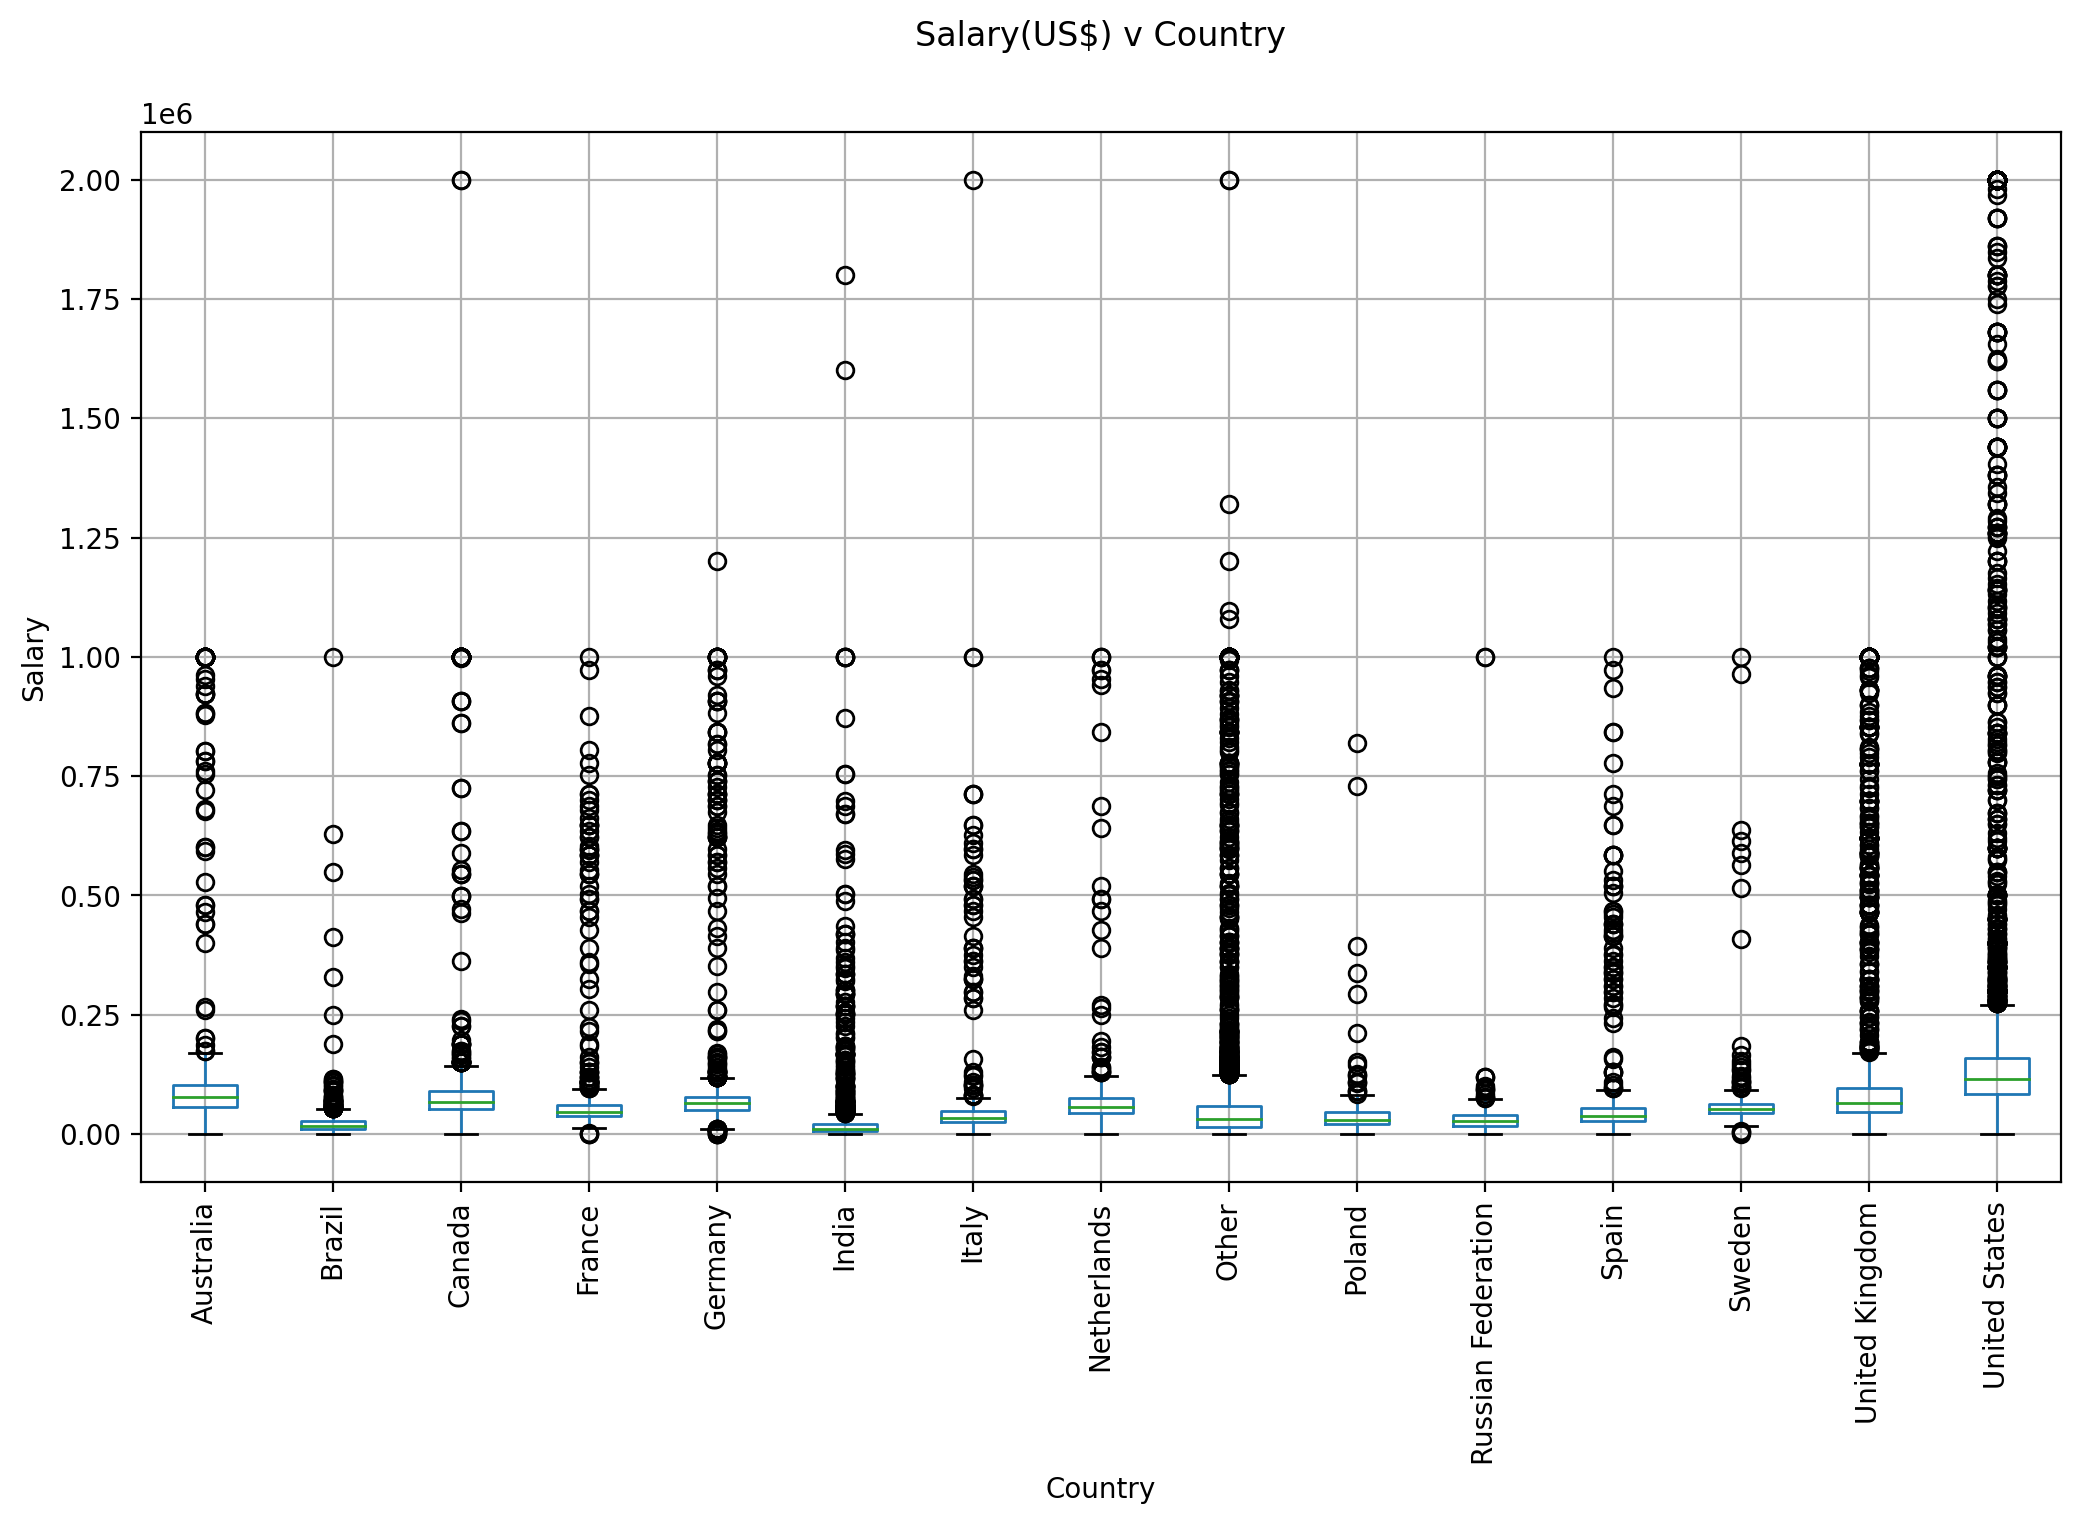

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,7),dpi=200)
df.boxplot('Salary','Country',ax=ax)
plt.suptitle('Salary(US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [9]:
# Refininf the Salary and removing outliers
df = df[df['Salary']<=250000]
df = df[df['Salary']>=10000]
# Droping the other category
df = df[df['Country']!='Other'] # it is case sensitive

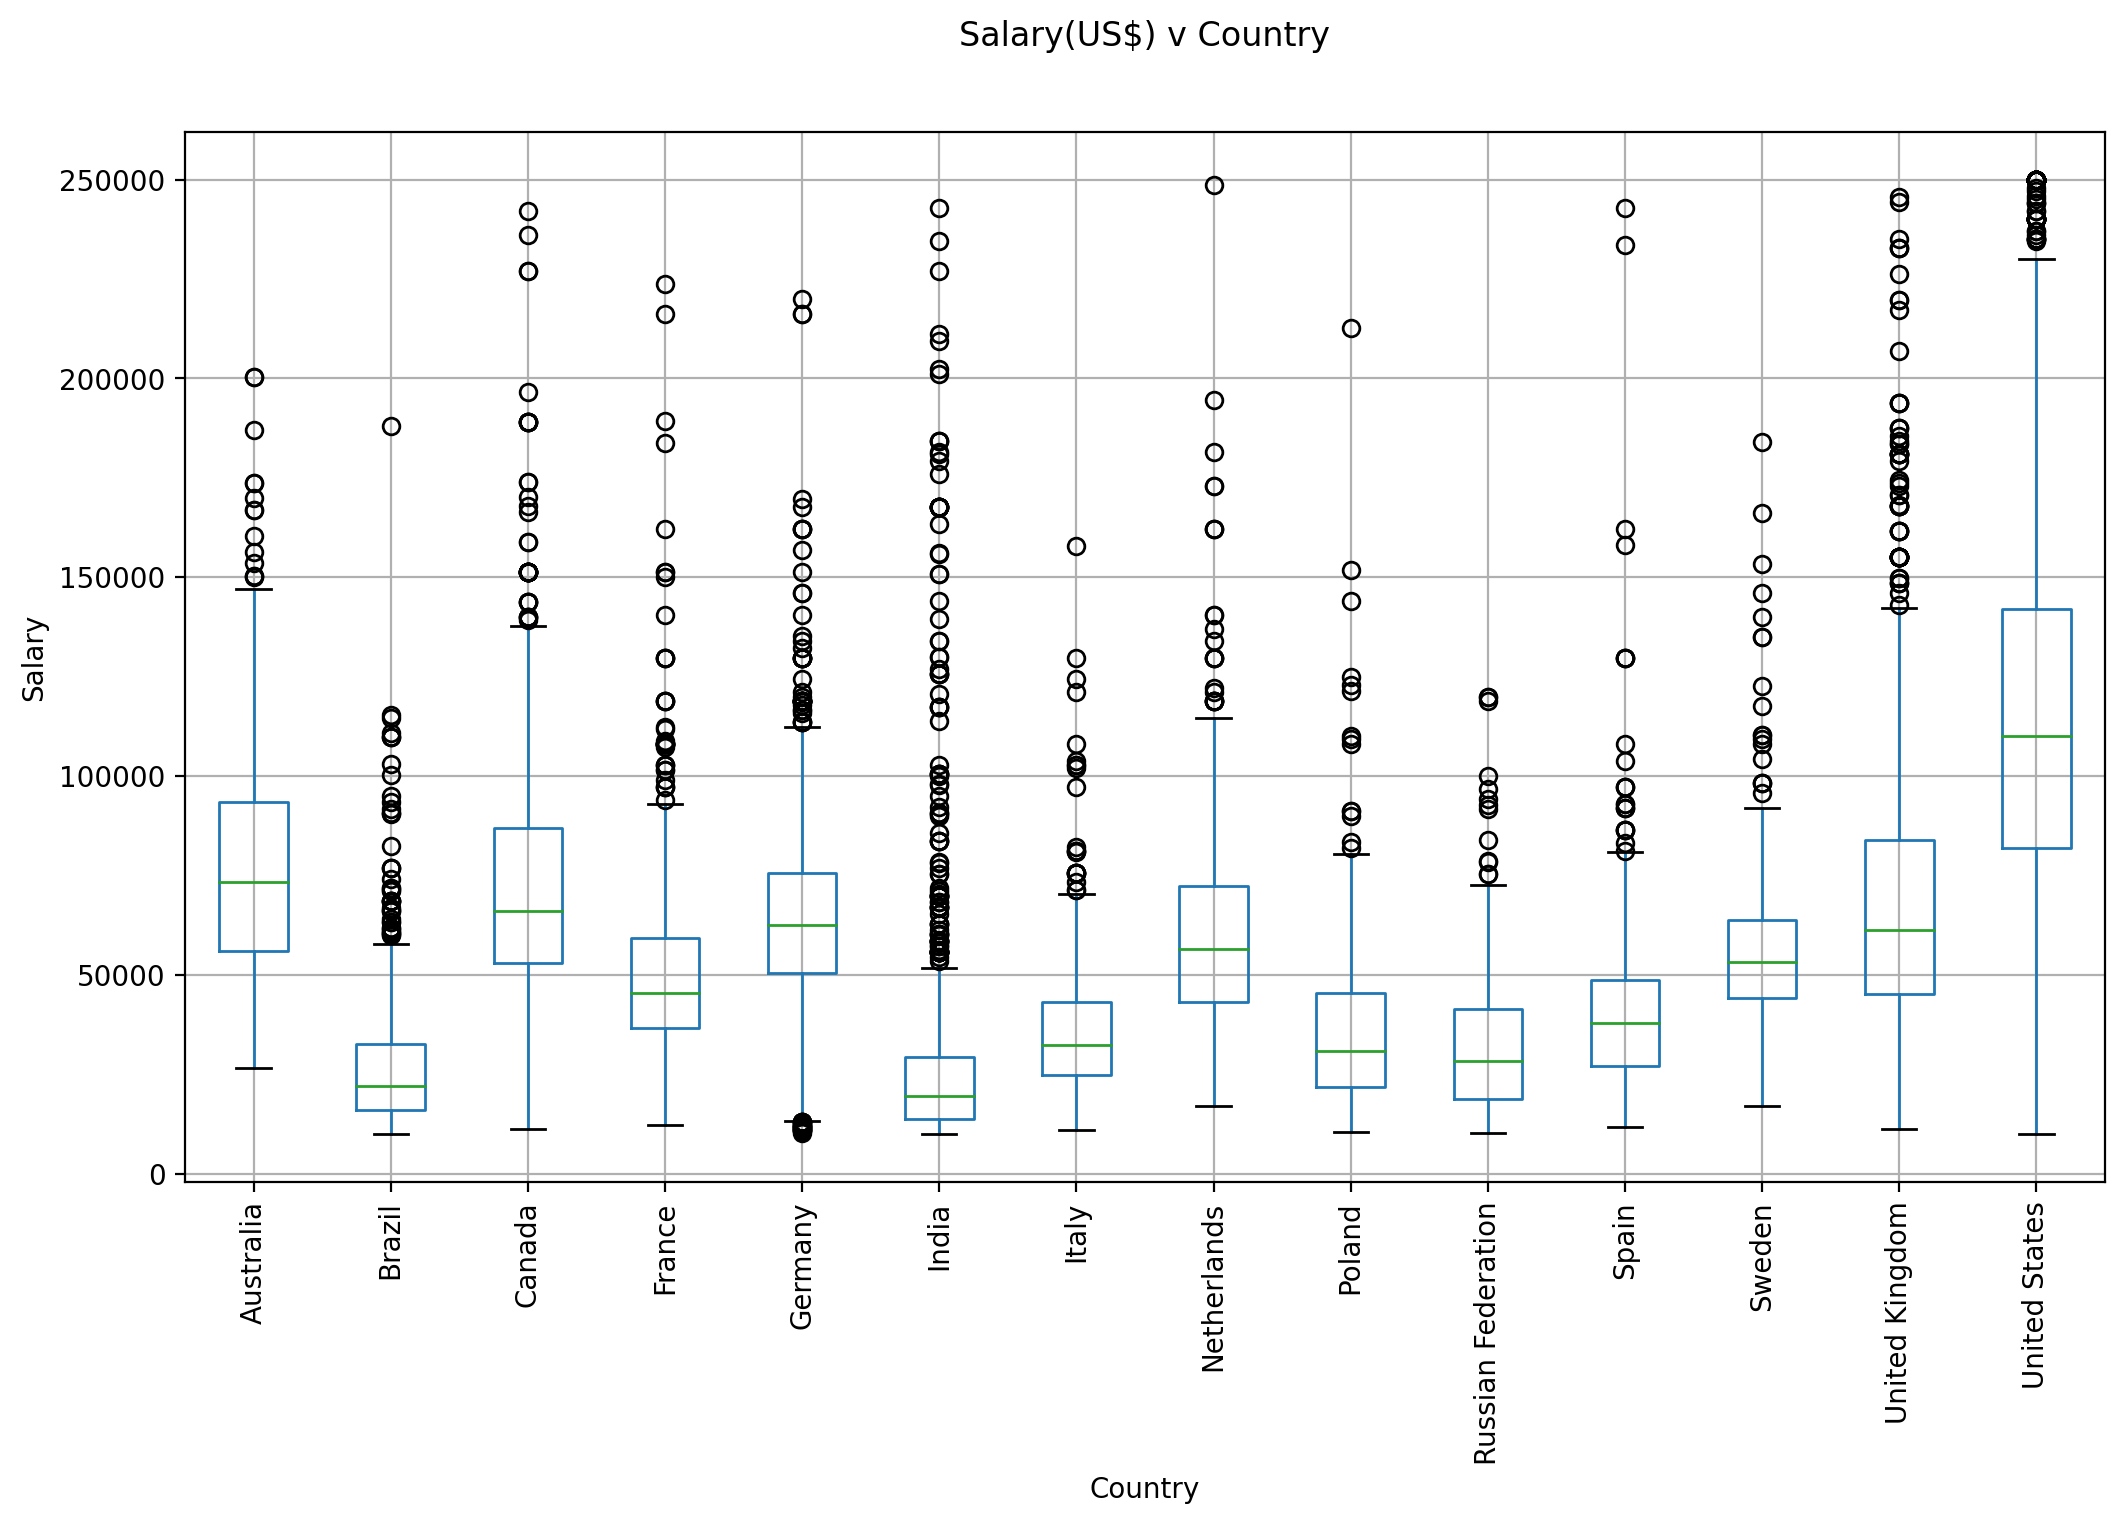

In [10]:
fig,ax = plt.subplots(1,1,figsize=(12,7),dpi=200)
df.boxplot('Salary','Country',ax=ax)
plt.suptitle('Salary(US$) v Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation=90)
plt.show()

In [11]:
# Refining YearsCodePro
df['YearsCodePro'].unique()

# Function to refine the age
def clean_exp(x):
    if x=="More than 50 years":
        return 50
    elif x=='Less than 1 year':
        return 0.5
    else:
        return float(x)

In [12]:
df["YearsCodePro"]=df['YearsCodePro'].apply(clean_exp)

In [13]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)
df.EdLevel.unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [14]:
# Enumerating Numerical values to strings for model to understand
from sklearn.preprocessing import LabelEncoder
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()

array([0, 2, 1, 3])

In [15]:
# For Countries
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df['Country'].unique()

array([13, 12, 10,  7,  4,  2,  6,  1,  3,  5, 11,  8,  0,  9])

In [16]:
# Since the values are not huge, we are not splitting data into testing and training
x = df.drop("Salary",axis=1) 
y = df['Salary']

## Testing Different Models

#### 1.Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(x,y.values)

LinearRegression()

In [18]:
y_pred = linear_reg.predict(x)

In [19]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
error = np.sqrt(mean_squared_error(y,y_pred))

In [20]:
error

39274.75368318509

### 2.Decision Tree Regressor

In [21]:
from sklearn.tree import DecisionTreeRegressor
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(x,y.values)

DecisionTreeRegressor(random_state=0)

In [22]:
y_pred = dec_tree_reg.predict(x)

In [23]:
error = np.sqrt(mean_squared_error(y,y_pred)) # Less error than linear regression

#### Grid Search Cross Validation

In [24]:
from sklearn.model_selection import GridSearchCV

max_depth = [None,2,4,6,8,10,12]
parameters = {"max_depth":max_depth}
regressor = DecisionTreeRegressor(random_state=0)
gs= GridSearchCV(regressor,parameters,scoring="neg_mean_squared_error")
gs.fit(x,y.values) # loops over all paramters and chooses the best model

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [25]:
regressor = gs.best_estimator_
regressor.fit(x,y.values)
y_pred = regressor.predict(x)
error = np.sqrt(mean_squared_error(y,y_pred))

In [28]:
x


,Country,EdLevel,YearsCodePro
7,13,0,13.0
9,12,2,4.0
10,12,0,2.0
11,10,1,7.0
12,7,1,20.0
...,...,...,...
64113,13,1,15.0
64116,13,0,6.0
64122,13,1,4.0
64127,13,3,12.0


In [29]:
# country, edlevel, yearscode
X = np.array([["United States", 'Master’s degree', 15 ]])
X

array([['United States', 'Master’s degree', '15']], dtype='<U15')

In [30]:
X[:,0]=le_country.transform(X[:,0])
X[:,1] = le_education.transform(X[:,1])
X= X.astype(float)
X

array([[13.,  2., 15.]])

In [31]:
y_pred = regressor.predict(X)
y_pred

array([139427.26315789])

In [33]:
# Saving the model using pickle
import pickle

In [37]:
# Saving the model as data and writing it to a file
data = {"model":regressor,"le_country":le_country,"le_education":le_education}
with open('saved_steps.pkl','wb') as file:
    pickle.dump(data,file)

In [39]:
# Loading pickle data
with open('saved_steps.pkl','rb') as file:
    data=pickle.load(file)
regressor_loaded = data["model"]
le_country = data["le_country"]
le_education=data["le_education"]

In [42]:
# predicting data
y_pred = regressor_loaded.predict(X)
y_pred

array([139427.26315789])